# Sales Prediction for Big Mart Outlets

## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 
The full problem statement can be found at the datathon webpage at [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement)

## Data Dictionary

Variable | Description
:---- | :----
Item_Identifier | Unique Product ID
Item_Weight | Weight of product
Item_Fat_Content | Whether the product is low fat or not
Item_Visibility | The % of total display area of all products in a store allocated to the particular product
Item_Type | 	The category to which the product belongs
Item _MRP | Maximum Retail Price (list price) of the product
Outlet_Identifier | 	Unique store ID
Outlet_Establishment_Year | 	The year in which store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_Location_Type | The type of city in which the store is located
Outlet_Type | 	Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particular store. This is the outcome variable to be predicted.

## Evaluation Metric

The evaluation metric is **Root Mean Squared Error**
***

## Exploring the data

In [178]:
# Importing necessary packages for data wrangling, visualizations and modelling.
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import data_cleaning
import missingno as mno
import matplotlib.pyplot as plt
from scipy import stats

In [179]:
train_df = pd.read_csv('data/train_kOBLwZA.csv')
test_df = pd.read_csv('data/test_t02dQwI.csv')
print('The shape of train data is {} and the shape of the test data is {}'.format(train.shape, test.shape))

The shape of train data is (8523, 12) and the shape of the test data is (5681, 10)


In [180]:
combi = pd.concat([train_df, test_df], ignore_index=True)
# combi['Outlet_Establishment_Year'] = combi['Outlet_Establishment_Year'].astype('object')
combi.shape

(14204, 12)

In [66]:
combi.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [67]:
combi.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year     object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Exploratory Data Analysis

In [181]:
from data_cleaning import initial_eda_checks
initial_eda_checks(combi)

Total and percentage NaN
                    Total   Percent
Item_Outlet_Sales   5681  0.399958
Outlet_Size         4016  0.282737
Item_Weight         2439  0.171712


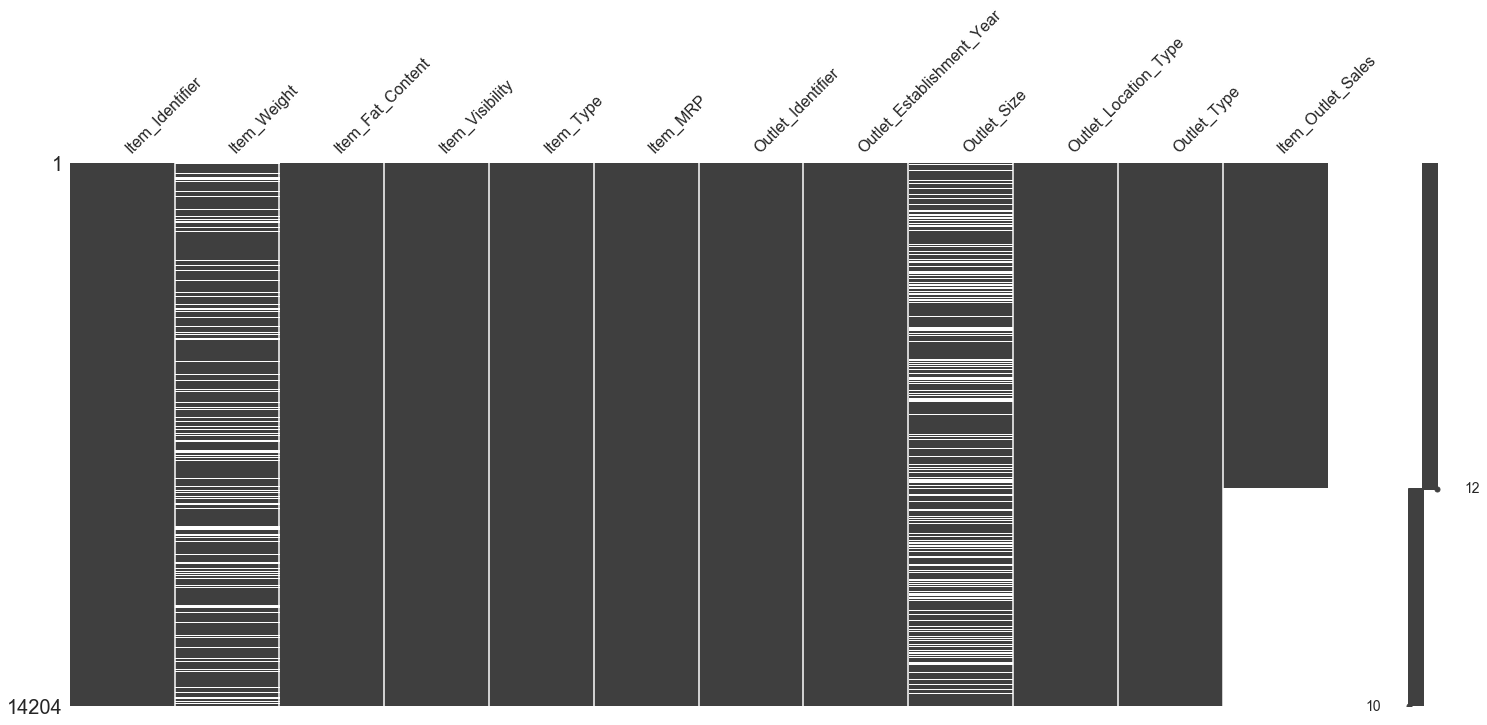

In [15]:
mno.matrix(combi)

In [182]:
## Checking number of unique entries for each variable
combi.apply(lambda x: x.nunique())

Item_Identifier               1559
Item_Weight                    415
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3493
dtype: int64

In [183]:
# Frequency of each unique entry in categorical columns
cat_cols = combi.select_dtypes(include=['object']).columns
def item_frequency(df, columns):
    for column in columns:
        print('frequency for each category in ', column)
        print(df[column].value_counts())
        print('***************************************')

item_frequency(combi, cat_cols)

frequency for each category in  Item_Identifier
NCX18    10
FDS12    10
FDC35    10
FDX31    10
FDL40    10
         ..
FDH58     7
FDM10     7
FDR51     7
FDL50     7
FDI46     7
Name: Item_Identifier, Length: 1559, dtype: int64
***************************************
frequency for each category in  Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
***************************************
frequency for each category in  Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Na

In [184]:
# Correcting for mistyped data

combi['Item_Fat_Content'].replace(to_replace=['low fat', 'reg', 'LF'],
                                 value = ['Low Fat', 'Regular', 'Low Fat'], inplace=True)


### Filling in average weight missing data

In [185]:
# Creating a pivot table of the means of each item for the non null values.

avg_item_weight = combi.pivot_table(values='Item_Weight', columns = 'Item_Identifier', aggfunc='mean')
avg_item_weight

Item_Identifier,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
Item_Weight,11.6,19.35,8.27,7.39,6.115,8.785,12.3,16.75,5.92,17.85,...,8.485,19.6,12.15,7.825,15.0,6.59,19.85,10.5,9.6,14.65


In [186]:
# A function that fills in the null values with the corresponding average weight of the item calculated in the pivot table above.
def item_wgt(columns):
    item = columns[0]
    weight = columns[1]
    if (pd.isnull(weight)):
        return avg_item_weight.loc['Item_Weight'][avg_item_weight.columns == item][0]
    else:
        return weight
    

    
    
combi['Item_Weight'] = combi[['Item_Identifier', 'Item_Weight']].apply(item_wgt, axis=1)

### Filling in Outlet Size missing data

In [187]:
# Creating a table the mode of each outlet's size outlet type.
outlet_size_mode = combi.pivot_table(values='Outlet_Size', columns='Outlet_Type',
                                     aggfunc=lambda x: x.mode())
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [188]:
#  Function that fills null values of outlet size with the corresponding mode of the outlet type
def impute_outlet_size(columns):
    size = columns[0]
    Type = columns[1]
    if pd.isnull(size):
        return outlet_size_mode.loc['Outlet_Size'][outlet_size_mode.columns == Type][0]
    else: 
        return size
    
combi['Outlet_Size'] = combi[['Outlet_Size','Outlet_Type']].apply(impute_outlet_size, axis=1)

In [189]:
data_cleaning.initial_eda_checks(combi)

Total and percentage NaN
                    Total   Percent
Item_Outlet_Sales   5681  0.399958


### Identifying Outliers

In [190]:
combi.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.065953,141.004977,1997.830681,2181.288914
std,4.651716,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [191]:
numerical_cols = combi.select_dtypes(include=['number']).columns
numerical_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

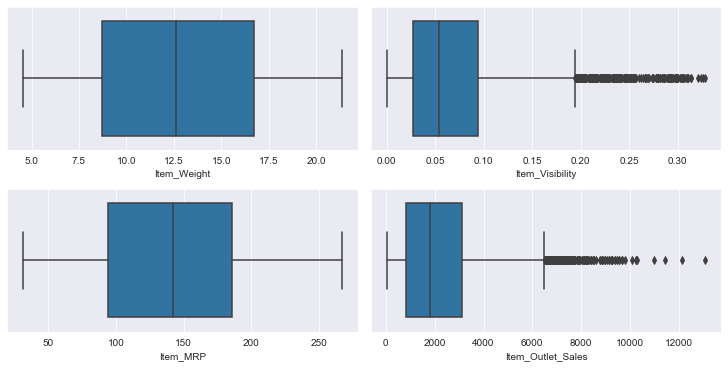

In [73]:
# boxplot subplot of all numerical columns 

num_plots = len(numerical_cols)
total_cols = 2
total_rows = 2
fig, axs = plt.subplots(nrows=2, ncols=2,
                       figsize=(10,5),
                       constrained_layout=True)

for i, var in enumerate(numerical_cols):
    row = i//total_cols
    pos=i%total_cols
    
    plot = sns.boxplot(x=var, data=combi, ax=axs[row][pos])

> Item visibility has a lot of outliers as well as the target variable, Item_outlet_sales.

In [58]:
# finding number of outliers in the columns using the Z value.

def number_of_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    z_value = Q3 + 1.5*IQR
    outliers = 0
    for i in column:
        if i > z_value:
            outliers = outliers + 1
    return outliers

In [60]:
# Number of outliers in the item visibility column
number_of_outliers(combi.Item_Visibility)

261

In [62]:
# Number of outliers in the target column.
out = number_of_outliers(combi.Item_Outlet_Sales)
(out/train_df.shape[0])*100


2.1823301654347063

> **2%** of values  in the target column are outliers.

## categorical variables countplots

#### Item type vs sales

<Figure size 1440x1440 with 0 Axes>

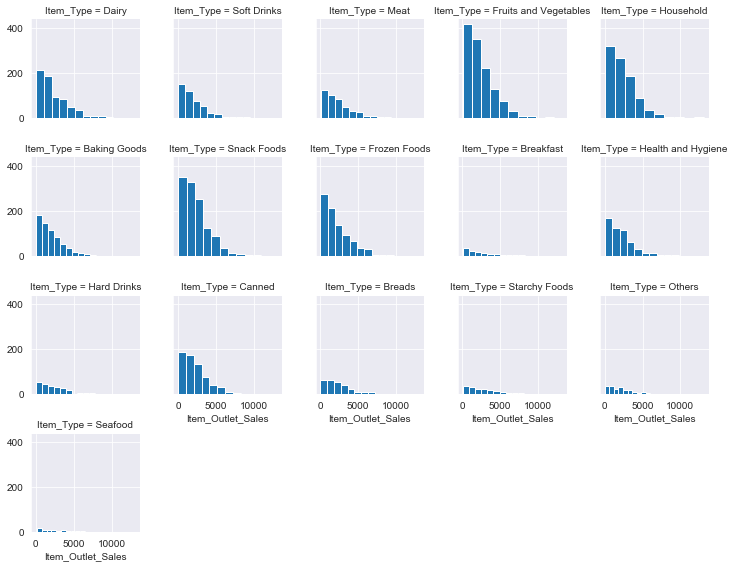

In [89]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Item_Type', size=2, col_wrap=5)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

### Location vs Sales

<Figure size 1440x1440 with 0 Axes>

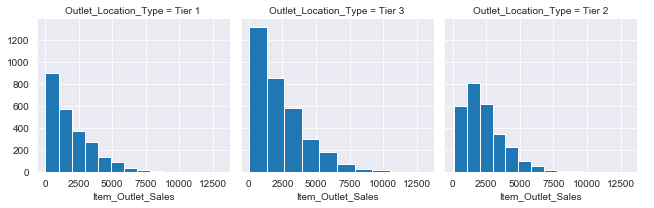

In [93]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Outlet_Location_Type', size=3, col_wrap=3)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

### Year vs sales

<Figure size 1440x1440 with 0 Axes>

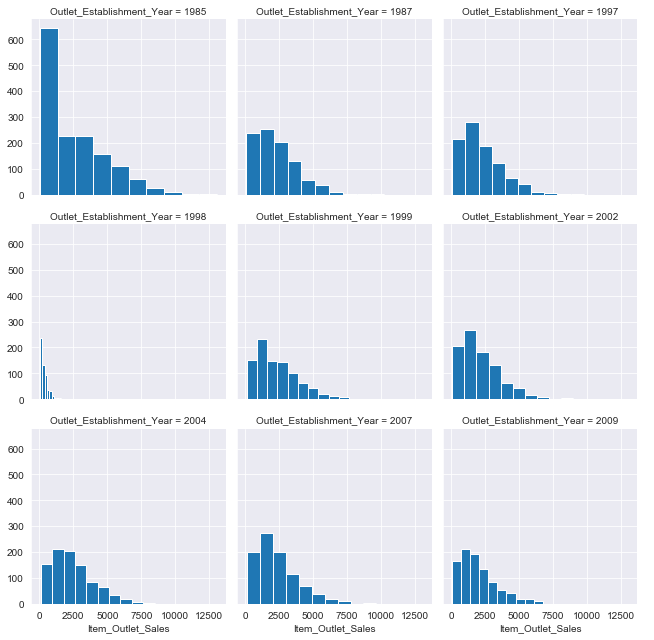

In [91]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Outlet_Establishment_Year', size=3, col_wrap=3)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

> 1998 does not seem to follow a similar trend as the rest of the years

### Outlet size vs sales

<Figure size 1440x1440 with 0 Axes>

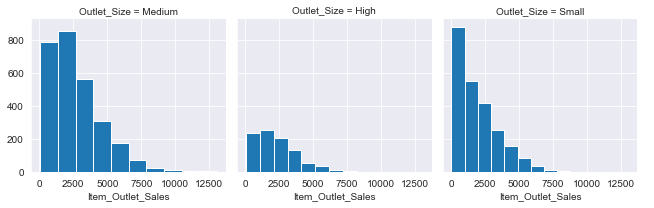

In [92]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Outlet_Size', size=3, col_wrap=3)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

> People generally prefer shopping in small and medium shops

### Fat content vs sales

<Figure size 1440x1440 with 0 Axes>

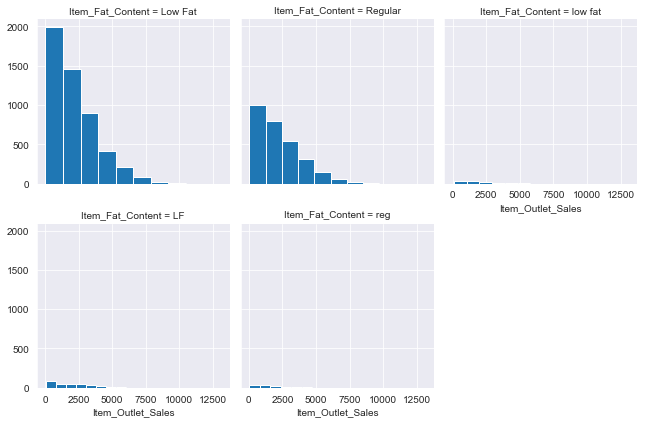

In [94]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Item_Fat_Content', size=3, col_wrap=3)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

### Outlet Type

<Figure size 1440x1440 with 0 Axes>

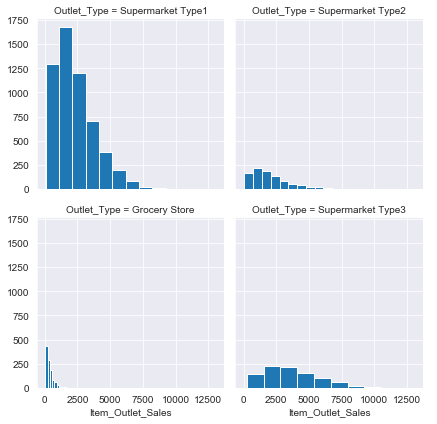

In [96]:
plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Outlet_Type', size=3, col_wrap=2)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

> * Supermarkets sell more then grocery stores
* people who buy in supermarket type 3 buy more than all other shop types

### Outlet_Identifier vs Sales

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1440x1440 with 0 Axes>

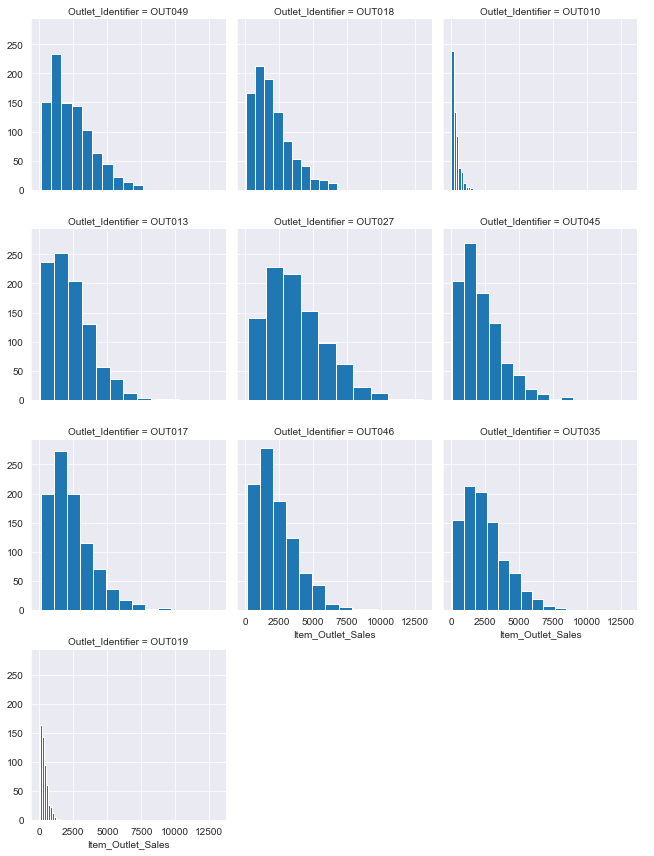

In [100]:

plt.figure(figsize=(20,20))
sns.FacetGrid(combi, col='Outlet_Identifier', size=3, col_wrap=3)\
    .map(plt.hist, 'Item_Outlet_Sales').add_legend();

> some outlets do well than others.

## Feature Engineering

In [192]:
combi['yearsold']=2013-combi['Outlet_Establishment_Year']
combi=combi.drop(columns=['Outlet_Establishment_Year'])
combi.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,yearsold
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26


In [193]:
# Creating a new feature from the first three letters from the item identifier column
combi['Item_Type_Combined'] = combi['Item_Identifier'].apply(lambda x: x[0:2])
combi['Item_Type_Combined'].replace(to_replace =['FD','DR','NC'], 
                 value =['Food','Drinks','Non_consumable'],inplace=True)
# dropping the redundant column
combi = combi.drop('Item_Type',1)
combi.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,yearsold,Item_Type_Combined
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14,Food
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4,Drinks
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14,Food
3,FDX07,19.20,Regular,0.000000,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15,Food
4,NCD19,8.93,Low Fat,0.000000,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26,Non_consumable


In [194]:
mask = combi['Item_Type_Combined'] == 'Non_consumable'
combi['Item_Fat_Content'][mask] = 'Non_edible'
combi['Item_Fat_Content'].value_counts()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Low Fat       6499
Regular       5019
Non_edible    2686
Name: Item_Fat_Content, dtype: int64

In [195]:
# COnverting all the zero values to mean in the visibility column
# This is because item visibility cannot be zero.

item_vis_mean = combi.pivot_table(values='Item_Visibility', columns='Item_Identifier', aggfunc='mean')
item_vis_mean

Item_Identifier,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
Item_Visibility,0.034938,0.045646,0.133384,0.079736,0.006799,0.020596,0.079407,0.023973,0.020653,0.037862,...,0.06303,0.102096,0.076568,0.180954,0.076774,0.027302,0.056396,0.011015,0.02633,0.081345


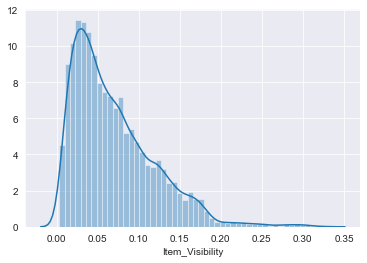

In [196]:
def item_vis_zero(columns):
    vis = columns[0]
    iid = columns[1]
    if vis == 0.0:
        return item_vis_mean.loc['Item_Visibility'][item_vis_mean.columns==iid][0]
    else:
        return vis
    
combi['Item_Visibility'] = combi[['Item_Visibility', 'Item_Identifier']].apply(item_vis_zero, axis=1)
sns.distplot(combi['Item_Visibility'],bins=50)

### Correlation matrix for numerical columns

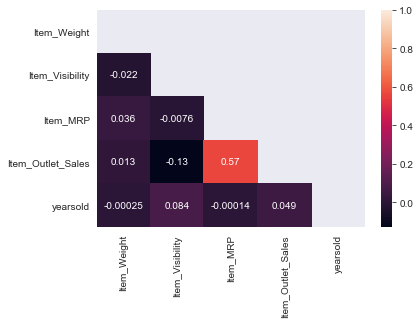

In [200]:
matrix = np.triu(combi.corr())
sns.heatmap(combi.corr(), annot=True, mask=matrix)

> No column has a high correlation with the target column

## Modelling and Ensembles

### Baseline model using Catboost's categorical encoder.

In [197]:
# Separating train and test datasets
train=combi.iloc[:8523,:]
test=combi.iloc[8523:,:]
test=test.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])

In [259]:
train.to_csv('data/train_clean.csv')

In [211]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,yearsold,Item_Type_Combined
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14,Food
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4,Drinks
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14,Food
3,FDX07,19.20,Regular,0.017834,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15,Food
4,NCD19,8.93,Non_edible,0.009780,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26,Non_consumable


In [248]:
X = train.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
y = train['Item_Outlet_Sales']
cat_cols = X.select_dtypes(include=['object']).columns

from catboost import CatBoostRegressor
error=[]
pred_test = np.zeros(len(test))
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat  = CatBoostRegressor(verbose= False,random_seed= 1234, use_best_model=True, cat_features=cat_cols, n_estimators=1000, learning_rate=0.05)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])
    preds=cat.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    error.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = cat.predict(test)
    pred_test+=p2
np.mean(error)

err:  1092.1713625096643
err:  1070.2143192645235
err:  1066.762493209058
err:  1067.836345598239
err:  1080.4002904602596


1075.476962208349

### Catboost with label and one-hot encoded categorical data

In [207]:
#Label Encoding all the columns with text entries and dropping Item_identifier  
df = combi.copy()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
list=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined',
      'Outlet_Size']
for i in list:
    le.fit(df[i])
    df[i]=le.transform(df[i])
df_new=df.drop(columns='Item_Identifier')
df_new= pd.get_dummies(df_new,columns=['Outlet_Identifier'])
df_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,yearsold,Item_Type_Combined,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1,0,1,3735.1380,14,1,0,0,0,0,0,0,0,0,0,1
1,5.92,2,0.019278,48.2692,1,2,2,443.4228,4,0,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1,0,1,2097.2700,14,1,0,0,0,0,0,0,0,0,0,1
3,19.20,2,0.017834,182.0950,2,2,0,732.3800,15,1,1,0,0,0,0,0,0,0,0,0
4,8.93,1,0.009780,53.8614,0,2,1,994.7052,26,2,0,1,0,0,0,0,0,0,0,0


In [209]:
#Separating test and train set
df_new_train=df_new.iloc[:8523,:]
df_new_test=df_new.iloc[8523:,:]
df_new_test=df_new_test.drop(columns=['Item_Outlet_Sales'])

X = df_new_train.drop(columns=['Item_Outlet_Sales'])
y = df_new_train['Item_Outlet_Sales']

error=[]
pred_test = np.zeros(len(df_new_test))
fold=KFold(n_splits=5)

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat  = CatBoostRegressor(verbose= False,random_seed= 1234)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])
    preds=cat.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    error.append(np.sqrt(mean_squared_error(y_test,preds)))
np.mean(error)

err:  1096.3649464155367
err:  1070.384758374671
err:  1069.5253072619648
err:  1071.4923900205933
err:  1082.7928980628526


1078.1120600271238

> Clearly, this is not the best approach!

### Mean encoding + catboost

In [243]:
x = train.drop(columns=['Item_Identifier'])
# Encoding the categorical features with their corresponding mean of the target variable
cat_cols = x.select_dtypes(include=['object']).columns

for column in cat_cols:
    x[column+'_encoded'] = x[column].map(x.groupby(column)['Item_Outlet_Sales'].mean())


x = x.drop(columns=cat_cols)    

x

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,yearsold,Item_Fat_Content_encoded,Outlet_Identifier_encoded,Outlet_Size_encoded,Outlet_Location_Type_encoded,Outlet_Type_encoded,Item_Type_Combined_encoded
0,9.300,0.016047,249.8092,3735.1380,14,2163.829268,2348.354635,2681.603542,1876.909159,2316.181148,2215.354223
1,5.920,0.019278,48.2692,443.4228,4,2224.561170,1995.498739,2681.603542,2279.627651,1995.498739,1997.333337
2,17.500,0.016760,141.6180,2097.2700,14,2163.829268,2348.354635,2681.603542,1876.909159,2316.181148,2215.354223
3,19.200,0.017834,182.0950,732.3800,15,2224.561170,339.351662,1867.182814,2279.627651,339.828500,2215.354223
4,8.930,0.009780,53.8614,994.7052,26,2142.721364,2298.995256,2298.995256,2279.627651,2316.181148,2142.721364
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,2778.3834,26,2163.829268,2298.995256,2298.995256,2279.627651,2316.181148,2215.354223
8519,8.380,0.046982,108.1570,549.2850,11,2224.561170,2192.384798,1867.182814,2323.990559,2316.181148,2215.354223
8520,10.600,0.035186,85.1224,1193.1136,9,2142.721364,2438.841866,1867.182814,2323.990559,2316.181148,2142.721364
8521,7.210,0.145221,103.1332,1845.5976,4,2224.561170,1995.498739,2681.603542,2279.627651,1995.498739,2215.354223


In [251]:
y = x['Item_Outlet_Sales']
X = x.drop('Item_Outlet_Sales',1)

error=[]
pred_test = np.zeros(len(test))

fold=KFold(n_splits=5)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat2  = CatBoostRegressor(verbose= False,random_seed= 1234, use_best_model=True, n_estimators=1000, learning_rate=0.05)
    cat2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])
    preds=cat2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    error.append(np.sqrt(mean_squared_error(y_test,preds)))
    
np.mean(error)

err:  1095.6186635520146
err:  1069.4999120116308
err:  1069.421184356403
err:  1071.8953195201848
err:  1081.4787262594205


1077.5827611399304

> mean encoding is slightly better than one-hot and label encoding but slightly worse than catboost's implementation of the same.

## Feature importances

### Catboost encoded

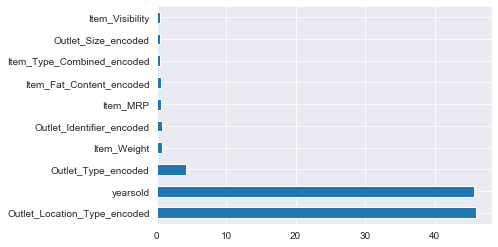

In [255]:
#Feature importance plot.

feat_importances = pd.Series(cat.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

### Catboost + mean encoding

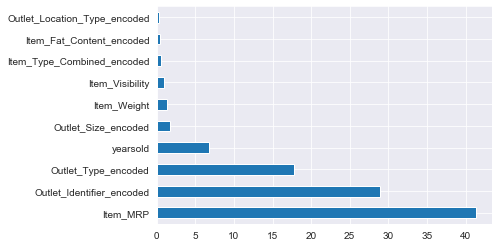

In [256]:
#Feature importance plot.

feat_importances = pd.Series(cat2.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

> There's a big difference in the most important features for both models. Therefore, while exploring feature interactions and ensembles, these differences should be taken into account.

### Stacking

In [260]:
import requests
from io import StringIO 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, StackingRegressor,HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
import warnings
from rgf.sklearn import RGFRegressor
warnings.filterwarnings('ignore')

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2020)

In [267]:
# In stacking, the most important thing is model diversification. from linear, SVM, KNN and Decision trees and many variations of them. The variations are different values of key parameters
# of each model. 
# While we did not have the time to tune parameters of each model, except the meta learner Catboost, educated guesses on the parameters were made to have as much variability as possible.
estimators_1 = [
    ('xgb', XGBRegressor(random_state=2020, objective ='reg:squarederror', learning_rate=0.05)),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=2020)),
    ('lgb', LGBMRegressor(learning_rate=0.2, random_state=2020)),
    ('svr', SVR(degree=2)),
    ('lasso', Lasso(random_state=2020)),
    ('kneiba', KNeighborsRegressor(n_neighbors=4)),
    ('cat', CatBoostRegressor(logging_level='Silent', random_state=2020))
]

stack1_preds = StackingRegressor(estimators=estimators_1, final_estimator=CatBoostRegressor(logging_level='Silent', depth=6, bagging_temperature=5, random_state=2020)).fit(X_train, y_train).predict(X_test)

estimators_2 = [
    ('xgb', XGBRegressor(objective ='reg:squarederror', learning_rate=0.2, random_state=2020)),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=2020)),
    ('lgb', LGBMRegressor(learning_rate=0.05, random_state=2020)),
    ('svr', SVR(degree=5)),
    ('lasso', Lasso(random_state=2020)),
    ('kneiba', KNeighborsRegressor(n_neighbors=6)),
    ('cat', CatBoostRegressor(logging_level='Silent', random_state=2020))
]

stack2_preds = StackingRegressor(estimators=estimators_2, final_estimator=CatBoostRegressor(logging_level='Silent', depth=6, bagging_temperature=5, random_state=2020)).fit(X_train, y_train).predict(X_test)

cat_1_preds = CatBoostRegressor(logging_level='Silent', depth=6, bagging_temperature=5, random_state=2020).fit(X_train, y_train).predict(X_test)


# Further averaging, blending and retraining to generalise well
stack = [x*0.5 + y*0.5 for x, y in zip(stack1_preds, stack2_preds)]
stack_2 = [x*0.5 + y*0.5 for x, y in zip(stack, cat_1_preds)]
print('The RMSE for the ensemble is {}'.format(np.sqrt(mean_squared_error(stack_2, y_test))))


The RMSE for the ensemble is 1063.650548655874


> We were able to improve our RMSE score from **1077** to **1063** using model stacking.